In [21]:
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from keras.datasets.mnist import load_data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def prepare_real_samples():
  (trainX, trainy), (testX, testy) = load_data()
  X = np.expand_dims(trainX,axis=-1)
  X = X.astype("float32")
  X = X / 255.0
  return X

In [0]:
#plt.imshow(trainX[2], cmap="gray_r")

In [0]:
def discriminator_model(input_shape = (28,28,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3) ,strides=(2,2), padding='same',input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3) ,strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.3))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  return model

In [5]:
model = discriminator_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [0]:
def generate_real_samples(dataset, n_samples):
  idx = randint(0,dataset.shape[0],n_samples)
  X = dataset[idx]
  y = np.ones((n_samples,1))
  return X,y

In [0]:
def generate_fake_samples(n_samples):
  X = rand(28*28*n_samples)
  X = X.reshape((n_samples,28,28,1))
  y = np.zeros((n_samples,1))
  return X,y

In [0]:
def train_discriminator(model,dataset,n_iter = 100,n_batches = 256):
  half_batch = int(n_batches/2)
  for i in range(n_iter):
    X_real, y_real = generate_real_samples(dataset,half_batch)
    _,real_acc = model.train_on_batch(X_real,y_real)
    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    print("At iteration " + str(i)+ " Real accuracy " + str(real_acc) + " fake accuracy "+ str(fake_acc))


In [9]:
model = discriminator_model()
dataset = prepare_real_samples()
train_discriminator(model,dataset)


11493376/11490434 [==============================] - 1s 0us/step
At iteration 0 Real accuracy 0.7265625 fake accuracy 0.1796875
At iteration 1 Real accuracy 0.828125 fake accuracy 0.4296875
At iteration 2 Real accuracy 0.796875 fake accuracy 0.6328125
At iteration 3 Real accuracy 0.7890625 fake accuracy 0.8046875
At iteration 4 Real accuracy 0.765625 fake accuracy 0.9296875
At iteration 5 Real accuracy 0.8203125 fake accuracy 0.9765625
At iteration 6 Real accuracy 0.8125 fake accuracy 1.0
At iteration 7 Real accuracy 0.7421875 fake accuracy 1.0
At iteration 8 Real accuracy 0.7265625 fake accuracy 1.0
At iteration 9 Real accuracy 0.734375 fake accuracy 1.0
At iteration 10 Real accuracy 0.7421875 fake accuracy 1.0
At iteration 11 Real accuracy 0.84375 fake accuracy 1.0
At iteration 12 Real accuracy 0.796875 fake accuracy 1.0
At iteration 13 Real accuracy 0.8203125 fake accuracy 1.0
At iteration 14 Real accuracy 0.8125 fake accuracy 1.0
At iteration 15 Real accuracy 0.7890625 fake accurac

Generator model

In [0]:
def generator_model(latent_dim = 100):
  model = Sequential()
  model.add(Dense(128*7*7,input_dim=latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation="sigmoid", padding="same"))
  return model

In [0]:
def generate_latent_points(latent_dim,n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples,latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model,latent_dim,n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples,1))
  return X, y

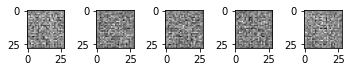

In [13]:
latent_dim = 100
model = generator_model(latent_dim)
n_samples = 5
X,_ = generate_fake_samples(model,latent_dim,n_samples)
for i in range(n_samples):
  plt.subplot(5,5,1+i)
  plt.imshow(X[i,:,:,0], cmap="gray_r")
plt.show()

In [0]:
def define_gan(generator, discriminator):
  generator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=opt)
  return model

In [0]:
def train_gan(generator, discriminator, gan_model, latent_dim , n_epochs, n_batch, dataset):
  batches_per_epoch = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real,y_real = generate_real_samples(dataset,half_batch)
      x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      X, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
      d_loss,_ = discriminator.train_on_batch(X,y)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print(i,j,batches_per_epoch,d_loss,g_loss)
    if (i+1) % 1000 == 0 :
      summarize_performance(i, generator, discriminator, dataset, latent_dim)



In [0]:
def summarize_performance(epoch,generator,discriminator,dataset,latent_dim,n_samples=100):
  x_real,y_real = generate_real_samples(dataset,n_samples)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  print("Real accuracy is " + str(acc_real)+ " and fake accuracy is "+ str(acc_fake))
  save_plot(x_fake, epoch)
  filename = "generator_model_%03d.h5" % (epoch + 1) 
  g_model.save(filename)



In [0]:
def save_plot(examples, epoch, n= 10):
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap="gray_r")
  filename = "generated_plot_e%03d.png" % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [18]:
latent_dim = 100
discriminator = discriminator_model()
generator = generator_model(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = prepare_real_samples()
train_gan(generator, discriminator, gan_model, latent_dim, 100,256,dataset)

Streaming output truncated to the last 5000 lines.
78 149 234 0.42053324 0.62253296
78 150 234 0.42220363 0.62719387
78 151 234 0.42406458 0.60931236
78 152 234 0.41896284 0.6127504
78 153 234 0.42373258 0.6169991
78 154 234 0.42592776 0.61797
78 155 234 0.42650196 0.6264457
78 156 234 0.43194017 0.6110947
78 157 234 0.4226397 0.61023307
78 158 234 0.4244774 0.6043469
78 159 234 0.4211156 0.61896896
78 160 234 0.4254114 0.6160881
78 161 234 0.42561758 0.611958
78 162 234 0.42208958 0.61713165
78 163 234 0.41895133 0.62115335
78 164 234 0.43299 0.62753487
78 165 234 0.42563674 0.6151534
78 166 234 0.4274997 0.6176184
78 167 234 0.43316683 0.62715596
78 168 234 0.42631555 0.62300223
78 169 234 0.4074797 0.6204199
78 170 234 0.4206677 0.6246433
78 171 234 0.42052534 0.6169566
78 172 234 0.41877988 0.62105167
78 173 234 0.41816512 0.62160695
78 174 234 0.42106718 0.6107717
78 175 234 0.42611146 0.61912495
78 176 234 0.41568577 0.6146761
78 177 234 0.431014 0.6130622
78 178 234 0.41318694 0

In [0]:

def save_plot(examples, n): # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis("off")

    plt.imshow(examples[i, :, :, 0], cmap="gray_r")
  plt.show()


In [0]:
generator.save("generator_model.h5")

In [41]:
model = load_model("generator_model.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 128)      